# **UTS Pencarian Penambangan Web**

In [ ]:
!pip install Sastrawi
!pip install gensim

#### Instalasi Library

In [ ]:
import os
import re
import string
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

## **Klasifikasi**

Klasifikasi adalah salah satu teknik dalam pembelajaran mesin (machine learning) yang bertujuan untuk mengelompokkan data ke dalam kategori tertentu berdasarkan pola dari data sebelumnya.

Pada UTS PPW kali ini kita akan melakukan klasifikasi menggunakan metode Naive Bayes dan SVM dengan membandingkan hasil akurasi mana yang terbaik.

Proses klasifikasi:

1. Pengumpulan Data
2. Eksplorasi Data
3. Prepocessing
    * case folding
    * cleansing
    * tokenisasi
    * stopword removel
    * stemming
4. Fitur Ekstraksi
5. Modeling (SVM & Naive Bayes)
6. Evaluasi


### **Pengumpulan Data**

Data didapatkan dari link: https://drive.google.com/file/d/1a776C4mmVbC-84gx_No0is9QDfpWFIme/view?usp=drive_link

Pengumpulan data dilakukan dengan download file `xlsx` dari link tersebut dan akan di upload lewat google colab

In [ ]:
import pandas as pd
from google.colab import files

print("📤 Silakan upload file 'berita.xlsx'")
uploaded = files.upload()

filename = list(uploaded.keys())[0]

data = pd.read_excel(filename)

print("✅ File berhasil dibaca!")
print("Jumlah data:", len(data))
print(data.head())


📤 Silakan upload file 'berita.xlsx'


Saving Berita.xlsx to Berita (2).xlsx
✅ File berhasil dibaca!
Jumlah data: 1500
   No                                              judul  \
0   1  Airlangga Harap Kenaikan UMP Tingkatkan Daya B...   
1   2  PT SIER Beri Penghargaan untuk 50 Tenant Terba...   
2   3  Prabowo Bakal Bentuk Kementerian Penerimaan Ne...   
3   4  Sinergi Kemenag & BPJS Ketenagakerjaan Lindung...   
4   5  Pemerintah Segera Bentuk Satgas PHK Usai Tetap...   

                                              berita  \
0  Menteri Koordinator (Menko) Bidang Perekonomia...   
1  Dalam rangka memeriahkan hari jadi ke-50, PT S...   
2  Wacana Presiden Prabowo Subianto akan membentu...   
3  BPJS Ketenagakerjaan dan Kementerian Agama (Ke...   
4  Pemerintah akan segera membentuk Satuan Tugas ...   

                         tanggal kategori  \
0  Minggu, 01 Des 2024 23:40 WIB  Ekonomi   
1  Minggu, 01 Des 2024 20:45 WIB  Ekonomi   
2  Minggu, 01 Des 2024 19:40 WIB  Ekonomi   
3  Minggu, 01 Des 2024 19:03 WIB  Ekonomi 

Tampilkan Data:

In [ ]:
print("\n📋 10 Baris Pertama Dataset:")
display(data.head(10))


📋 10 Baris Pertama Dataset:


,No,judul,berita,tanggal,kategori,link
0,1,Airlangga Harap Kenaikan UMP Tingkatkan Daya B...,Menteri Koordinator (Menko) Bidang Perekonomia...,"Minggu, 01 Des 2024 23:40 WIB",Ekonomi,https://www.cnnindonesia.com/ekonomi/202412012...
1,2,PT SIER Beri Penghargaan untuk 50 Tenant Terba...,"Dalam rangka memeriahkan hari jadi ke-50, PT S...","Minggu, 01 Des 2024 20:45 WIB",Ekonomi,https://www.cnnindonesia.com/ekonomi/202412012...
2,3,Prabowo Bakal Bentuk Kementerian Penerimaan Ne...,Wacana Presiden Prabowo Subianto akan membentu...,"Minggu, 01 Des 2024 19:40 WIB",Ekonomi,https://www.cnnindonesia.com/ekonomi/202412011...
3,4,Sinergi Kemenag & BPJS Ketenagakerjaan Lindung...,BPJS Ketenagakerjaan dan Kementerian Agama (Ke...,"Minggu, 01 Des 2024 19:03 WIB",Ekonomi,https://www.cnnindonesia.com/ekonomi/202412011...
4,5,Pemerintah Segera Bentuk Satgas PHK Usai Tetap...,Pemerintah akan segera membentuk Satuan Tugas ...,"Minggu, 01 Des 2024 19:00 WIB",Ekonomi,https://www.cnnindonesia.com/ekonomi/202412011...
5,6,AHY Buka-bukaan Nasib Kelanjutan Pembangunan I...,Menko Bidang Infrastruktur dan Pembangunan Kew...,"Minggu, 01 Des 2024 18:20 WIB",Ekonomi,https://www.cnnindonesia.com/ekonomi/202412011...
6,7,Badan Gizi Soal Biaya Makan Gratis Rp10 Ribu: ...,Kepala Badan Gizi Nasional Dadan Hindayana men...,"Senin, 02 Des 2024 21:00 WIB",Ekonomi,https://www.cnnindonesia.com/ekonomi/202412022...
7,8,Zulhas Minta Tambahan Anggaran Rp510 M Demi Ca...,Menteri Koordinator Bidang Pangan Zulkifli Has...,"Senin, 02 Des 2024 20:45 WIB",Ekonomi,https://www.cnnindonesia.com/ekonomi/202412021...
8,9,PLN Akan Uji Coba PLTS IKN 22 Desember,Uji coba alias commissioning pembangkit listri...,"Senin, 02 Des 2024 20:20 WIB",Ekonomi,https://www.cnnindonesia.com/ekonomi/202412021...
9,10,"Profil Jhony Saputra, Anak Haji Isam yang Jadi...",Anak crazy rich pengusaha sawit Kalimantan Sam...,"Senin, 02 Des 2024 20:00 WIB",Ekonomi,https://www.cnnindonesia.com/ekonomi/202412021...


### **Eksplorasi Data**

Eksplorasi data dilakukan agar lebih mengetahui data tersebut bagaimana, apakah data tersebut bersih atau masih ada nois seperti missing value dan duplikasi

In [ ]:
print("\nInformasi dataset:")
print(data.info())

print("\nJumlah missing value per kolom:")
print(data.isnull().sum())

missing_percent = (data.isnull().sum() / len(data)) * 100
print("\nPersentase missing value per kolom (%):")
print(missing_percent)
print("\nJumlah data duplikat:", data.duplicated().sum())




Informasi dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   No        1500 non-null   int64 
 1   judul     1500 non-null   object
 2   berita    1500 non-null   object
 3   tanggal   1500 non-null   object
 4   kategori  1500 non-null   object
 5   link      1500 non-null   object
dtypes: int64(1), object(5)
memory usage: 70.4+ KB
None

Jumlah missing value per kolom:
No          0
judul       0
berita      0
tanggal     0
kategori    0
link        0
dtype: int64

Persentase missing value per kolom (%):
No          0.0
judul       0.0
berita      0.0
tanggal     0.0
kategori    0.0
link        0.0
dtype: float64

Jumlah data duplikat: 0


Pada data terlihat tidak adanya Missing value dan Duplikasi

In [ ]:
# Deteksi kolom teks/label secara heuristik
columns = [c.lower() for c in data.columns]
col_map = {c.lower(): c for c in data.columns}

# Heuristik umum untuk dataset berita
candidate_text_cols = [c for c in columns if any(k in c for k in ["teks", "text", "berita", "konten", "isi", "judul", "headline", "content"])]
candidate_label_cols = [c for c in columns if any(k in c for k in ["label", "kategori", "kelas", "topik", "class", "category"])]

text_col = col_map[candidate_text_cols[0]] if candidate_text_cols else df.columns[0]
label_col = col_map[candidate_label_cols[0]] if candidate_label_cols else df.columns[-1]

print("Detected text column:", text_col)
print("Detected label column:", label_col)

# Bersihkan NA dan standarkan nama kolom
data = data[[text_col, label_col]].dropna().copy()
data = data.rename(columns={text_col: "text", label_col: "label"})

# Lihat distribusi label (cuplikan)
print("Labels (sample):", data["label"].value_counts().head())
print(data.shape)
data.head()

Detected text column: judul
Detected label column: kategori
Labels (sample): label
Ekonomi          375
Olahraga         375
Nasional         375
Internasional    375
Name: count, dtype: int64
(1500, 2)


,text,label
0,Airlangga Harap Kenaikan UMP Tingkatkan Daya B...,Ekonomi
1,PT SIER Beri Penghargaan untuk 50 Tenant Terba...,Ekonomi
2,Prabowo Bakal Bentuk Kementerian Penerimaan Ne...,Ekonomi
3,Sinergi Kemenag & BPJS Ketenagakerjaan Lindung...,Ekonomi
4,Pemerintah Segera Bentuk Satgas PHK Usai Tetap...,Ekonomi


Data mempunyai label atau kategori yang tersebar rata 375 tiap label

### **Prepocessing**

Preprocessing (pra-pemrosesan) adalah tahap awal dalam pengolahan data teks yang bertujuan untuk membersihkan, menormalkan, dan mempersiapkan teks agar bisa diproses oleh komputer atau algoritma machine learning.

#### Import Library

Import library untuk kebutuhan prepocessing:

In [ ]:
import re
import nltk
import pandas as pd
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

try:
    _ = stopwords.words('indonesian')
except LookupError:
    nltk.download('stopwords')
    _ = stopwords.words('indonesian')


#### Case Folding

Dalam prepocessing tentunya kita butuh case folding agar dapat menselaraskan semua huruf ke besar atau kecil semua, disini saya ubah menjadi huruf kecil semua

In [ ]:
def case_folding(text):
    return str(text).lower()


#### Cleaning

Pembersihan teks juga perlu untuk menghilangkan karakter asing selain huruf abjad

In [ ]:
def cleaning(text):
    # hanya ambil huruf dan spasi
    text = re.sub(r'[^a-zA-ZÀ-ÖØ-öø-ÿ\s]', ' ', text)
    # hapus spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()
    return text


#### Tokenisasi

Tokenisasi digunakan agar dapat memisaj setiap kata terhadap suatu kalimat

In [ ]:
TOKEN_RE = re.compile(r"[A-Za-zÀ-ÖØ-öø-ÿ]+", re.UNICODE)

def tokenisasi(text):
    return TOKEN_RE.findall(text)


#### **Stopword**

Stopword adalah proses untuk menghapus kata yang tidak perlu atau bukan kata inti atau kata imbuhan. Karena data teks berupa bahasa indonesia, maka perlu disesuaikan penghapusan dalam stopword indonesia

In [ ]:
indo_stopwords = set(stopwords.words('indonesian'))
extra_stops = {"rt", "yg", "dgn", "nya", "sih", "aja", "dll", "tuh", "nih"}
indo_stopwords |= extra_stops

def hapus_stopword(tokens):
    return [tok for tok in tokens if tok not in indo_stopwords and len(tok) > 2]


#### Stemming

Stemming digunakan untuk menghapus kata imbuhan dan  merubah kata ke kata asal, misal berubah menjadi ubah . digunakan untuk menyragamkan kata mnegurangi noise aerta mengurangi jumlah kata unik

In [ ]:
stemmer = StemmerFactory().create_stemmer()

def stemming(tokens):
    return [stemmer.stem(tok) for tok in tokens]

def normalize_text(text):
    text = case_folding(text)
    text = cleaning(text)
    tokens = tokenisasi(text)
    tokens = hapus_stopword(tokens)
    tokens = stemming(tokens)
    return " ".join(tokens)

#### Hasil Prepocessing

In [ ]:
# Jalankan ulang mulai dari sini:
data['clean'] = data['text'].astype(str).map(normalize_text)
data = data[data['clean'].str.strip().astype(bool)]
print(data.shape)

data['clean'] = data['text'].astype(str).map(normalize_text)

# Hapus baris yang kosong setelah pembersihan
data = data[data['clean'].str.strip().astype(bool)]

# ============================================================
# 📊 8. Tampilkan Hasil
# ============================================================
print("Jumlah data setelah preprocessing:", data.shape)
print(data[['text', 'clean', 'label']].head(10))

(1500, 3)
Jumlah data setelah preprocessing: (1500, 3)
                                                text  \
0  Airlangga Harap Kenaikan UMP Tingkatkan Daya B...   
1  PT SIER Beri Penghargaan untuk 50 Tenant Terba...   
2  Prabowo Bakal Bentuk Kementerian Penerimaan Ne...   
3  Sinergi Kemenag & BPJS Ketenagakerjaan Lindung...   
4  Pemerintah Segera Bentuk Satgas PHK Usai Tetap...   
5  AHY Buka-bukaan Nasib Kelanjutan Pembangunan I...   
6  Badan Gizi Soal Biaya Makan Gratis Rp10 Ribu: ...   
7  Zulhas Minta Tambahan Anggaran Rp510 M Demi Ca...   
8             PLN Akan Uji Coba PLTS IKN 22 Desember   
9  Profil Jhony Saputra, Anak Haji Isam yang Jadi...   

                                               clean    label  
0  airlangga harap naik ump tingkat daya beli mas...  Ekonomi  
1                         sier harga tenant baik hut  Ekonomi  
2  prabowo bentuk menteri terima negara pimpin an...  Ekonomi  
3  sinergi kemenag bpjs ketenagakerjaan lindung r...  Ekonomi  
4       

Data yang sudah dilaklukan pemrosesan teks akan ditampilkan dengan sesuai hasil prepocessing

### **Fitur Ekstraksi**

ekstraksi fitur berarti mengubah teks mentah menjadi representasi numerik (angka-angka) agar bisa diproses oleh algoritma machine learning. kita akan menggunakan LDA

#### **LDA**
LDA adalah model statistik yang menemukan pola topik tersembunyi (latent topics) dari sekumpulan dokumen.

Konsepnya:

* Setiap dokumen terdiri dari beberapa topik (dengan proporsi tertentu).

* Setiap topik terdiri dari beberapa kata yang sering muncul bersama.

Jadi LDA mencoba “menemukan” topik-topik seperti ini secara otomatis dari teks.

In [ ]:
# Bangun kamus dan korpus untuk LDA
texts = [doc.split() for doc in data['clean'].tolist()]

# Saring kata yang terlalu jarang/terlalu umum agar topik lebih stabil
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Representasi bag-of-words per dokumen
corpus = [dictionary.doc2bow(t) for t in texts]

# Latih model LDA (jumlah topik dapat disetel)
num_topics = 50     #jumlah topik yang akan dipelajari oleh LDA.
passes = 20      #berapa kali LDA “mengulang” membaca seluruh korpus saat training.
random_state = 42     #seed acak agar hasil LDA dan pembagian data reproducible (hasil sama tiap dijalankan)

lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes, random_state=random_state)

# Ekstrak distribusi topik per dokumen sebagai vektor berdimensi num_topics
def get_topic_vector(bow):
    topics = lda.get_document_topics(bow, minimum_probability=0)  # selalu kembalikan semua topik
    vec = np.zeros(num_topics, dtype=np.float32)
    for topic_id, prob in topics:
        vec[topic_id] = prob
    return vec

X_topics = np.vstack([get_topic_vector(b) for b in corpus])
y = data['label'].astype(str).values

print(X_topics.shape, len(y))

(1500, 50) 1500


Tahap ini bertujuan untuk melakukan ekstraksi fitur berbasis topik menggunakan metode Latent Dirichlet Allocation (LDA).
Metode ini digunakan untuk menemukan pola topik tersembunyi (latent topics) dari kumpulan teks berita dan mengubah setiap dokumen menjadi vektor numerik yang mewakili proporsi kontribusi tiap topik.

1. Membangun Kamus dan Korpus
2. Membangun Representasi Bag-of-Words
3. Melatih Model LDA
4. Mengubah Dokumen Menjadi Vektor Topik
5. Membentuk Matriks Fitur Akhir
6. Menampilkan Hasil Dimensi

Kode ini secara keseluruhan melakukan proses ekstraksi fitur berbasis topik (Topic-Based Feature Extraction) menggunakan metode Latent Dirichlet Allocation (LDA).
Hasil akhirnya adalah representasi numerik dari teks di mana setiap dokumen dinyatakan sebagai vektor probabilitas topik.
Fitur ini nantinya dapat digunakan untuk proses klasifikasi teks (misalnya dengan Naïve Bayes atau SVM), karena setiap berita telah dikonversi dari teks menjadi bentuk angka yang dapat dipahami oleh model pembelajaran mesin.

### **Modelling**

Modeling (pemodelan) adalah tahap di mana sistem mempelajari pola dari data menggunakan algoritma tertentu agar dapat melakukan prediksi atau klasifikasi terhadap data baru. klasifikasi berita menggunakan TF-IDF, Naïve Bayes, dan SVM

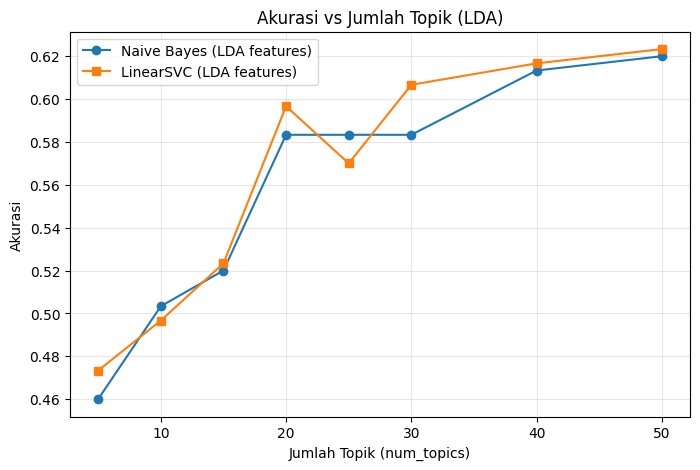

Best NB: topics=50 acc=0.6200
Best SVM: topics=50 acc=0.6233


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

texts_all = [doc.split() for doc in data['clean'].tolist()]
y_all = data['label'].astype(str).values

topic_grid = [5, 10, 15, 20, 25, 30, 40, 50]

results_nb = []
results_svm = []

for k in topic_grid:
    dictionary_k = corpora.Dictionary(texts_all)
    dictionary_k.filter_extremes(no_below=5, no_above=0.5)
    corpus_k = [dictionary_k.doc2bow(t) for t in texts_all]

    lda_k = LdaModel(
        corpus=corpus_k,
        id2word=dictionary_k,
        num_topics=k,
        passes=20,
        iterations=100,
        random_state=42
    )

    def doc_topic_vec(bow):
        vec = np.zeros(k, dtype=np.float32)
        for tid, prob in lda_k.get_document_topics(bow, minimum_probability=0):
            vec[tid] = prob
        return vec

    X_k = np.vstack([doc_topic_vec(b) for b in corpus_k])

    Xtr, Xte, ytr, yte = train_test_split(X_k, y_all, test_size=0.2, random_state=42, stratify=y_all)
    nb = MultinomialNB()
    nb.fit(Xtr, ytr)
    pred_nb = nb.predict(Xte)
    acc_nb = accuracy_score(yte, pred_nb)
    results_nb.append(acc_nb)

    # Linear SVM
    svm = LinearSVC(random_state=42)
    svm.fit(Xtr, ytr)
    pred_svm = svm.predict(Xte)
    acc_svm = accuracy_score(yte, pred_svm)
    results_svm.append(acc_svm)

# Plot hasil
plt.figure(figsize=(8,5))
plt.plot(topic_grid, results_nb, marker='o', label='Naive Bayes (LDA features)')
plt.plot(topic_grid, results_svm, marker='s', label='LinearSVC (LDA features)')
plt.xlabel('Jumlah Topik (num_topics)')
plt.ylabel('Akurasi')
plt.title('Akurasi vs Jumlah Topik (LDA)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

best_nb_idx = int(np.argmax(results_nb))
best_svm_idx = int(np.argmax(results_svm))
print(f"Best NB: topics={topic_grid[best_nb_idx]} acc={results_nb[best_nb_idx]:.4f}")
print(f"Best SVM: topics={topic_grid[best_svm_idx]} acc={results_svm[best_svm_idx]:.4f}")

In [ ]:
# Bagi data latih/uji secara stratified
X_train, X_test, y_train, y_test = train_test_split(
    X_topics, y, test_size=0.2, random_state=42, stratify=y
)

# Naive Bayes Multinomial cocok untuk fitur non-negatif (probabilitas topik memenuhi syarat)
nb_clf = MultinomialNB()
nb_clf.fit(X_train, y_train)
nb_pred = nb_clf.predict(X_test)

print("Naive Bayes Accuracy:", accuracy_score(y_test, nb_pred))
print(classification_report(y_test, nb_pred))

# LinearSVC di fitur probabilitas topik
svm_clf = LinearSVC(random_state=42)
svm_clf.fit(X_train, y_train)
svm_pred = svm_clf.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, svm_pred))
print(classification_report(y_test, svm_pred))

Naive Bayes Accuracy: 0.6166666666666667
               precision    recall  f1-score   support

      Ekonomi       0.54      0.60      0.57        75
Internasional       0.68      0.67      0.67        75
     Nasional       0.49      0.57      0.53        75
     Olahraga       0.84      0.63      0.72        75

     accuracy                           0.62       300
    macro avg       0.64      0.62      0.62       300
 weighted avg       0.64      0.62      0.62       300

SVM Accuracy: 0.6233333333333333
               precision    recall  f1-score   support

      Ekonomi       0.55      0.63      0.59        75
Internasional       0.70      0.68      0.69        75
     Nasional       0.50      0.53      0.52        75
     Olahraga       0.79      0.65      0.72        75

     accuracy                           0.62       300
    macro avg       0.64      0.62      0.63       300
 weighted avg       0.64      0.62      0.63       300



In [ ]:
# Baseline TF-IDF + LinearSVC
# Menggunakan representasi TF-IDF n-gram (1-2) yang umum kuat untuk klasifikasi teks berita
from sklearn.feature_extraction.text import TfidfVectorizer

# Bangun matriks TF-IDF dari teks yang sudah dibersihkan
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2), min_df=3)
X_tfidf = vectorizer.fit_transform(data['clean'])

# Bagi data latih/uji yang konsisten dengan eksperimen LDA
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

# Latih LinearSVC pada fitur TF-IDF
svm_tfidf = LinearSVC(random_state=42)
svm_tfidf.fit(X_train2, y_train2)
svm_tfidf_pred = svm_tfidf.predict(X_test2)

# Tampilkan metrik akurasi dan laporan klasifikasi
print("TF-IDF LinearSVC Accuracy:", accuracy_score(y_test2, svm_tfidf_pred))
print(classification_report(y_test2, svm_tfidf_pred))

TF-IDF LinearSVC Accuracy: 0.8933333333333333
               precision    recall  f1-score   support

      Ekonomi       0.82      0.93      0.88        75
Internasional       0.95      0.95      0.95        75
     Nasional       0.84      0.79      0.81        75
     Olahraga       0.97      0.91      0.94        75

     accuracy                           0.89       300
    macro avg       0.90      0.89      0.89       300
 weighted avg       0.90      0.89      0.89       300



### **Evaluasi**

**Hasil akurasi:**

1. Naive Bayes: 0.616
2. SVM: 0.623
3. TF-IDF LinearSVC: 0.89

* Kedua model memiliki kinerja mirip — hanya selisih sekitar 0.6 %.
Artinya, performa model saat ini cukup seimbang namun belum tinggi (masih sekitar 62 %).

* SVM unggul sedikit karena lebih kuat terhadap korelasi kata.


representasi TF-IDF jauh lebih informatif dibanding vektor topik LDA untuk klasifikasi teks berita



## **Clustering**

Clustering adalah proses mengelompokkan data ke dalam beberapa grup (cluster) berdasarkan kemiripan karakteristik antar data.

Pada UTS kali ini kita akan




### **Pengumpulan Data**

In [ ]:
import pandas as pd
from google.colab import files

print("📤 Silakan upload file 'spam.csv'")
uploaded = files.upload()

filename = list(uploaded.keys())[0]

encodings = ['utf-8', 'latin1', 'iso-8859-1', 'cp1252']
data_spam = None

for enc in encodings:
    try:
        data_spam = pd.read_csv(filename, encoding=enc)
        print(f"✅ File berhasil dibaca dengan encoding: {enc}")
        break
    except UnicodeDecodeError:
        print(f"⚠️ Gagal membaca dengan encoding: {enc}")
        continue
if data_spam is not None:
    if {'id', 'Text'}.issubset(data_spam.columns):
        data_spam = data_spam[['id', 'Text']]
        print("Jumlah data:", len(data_spam))
        display(data_spam.head(10))
    else:
        print("❌ Kolom 'id' dan/atau 'Text' tidak ditemukan dalam file.")
        print("Kolom yang tersedia:", list(data_spam.columns))
else:
    print("❌ Gagal membaca file dengan semua encoding yang dicoba.")


📤 Silakan upload file 'spam.csv'


Saving spam (1).csv to spam (1).csv
⚠️ Gagal membaca dengan encoding: utf-8
✅ File berhasil dibaca dengan encoding: latin1
Jumlah data: 5572


,id,Text
0,1,"Go until jurong point, crazy.. Available only ..."
1,2,Ok lar... Joking wif u oni...
2,3,Free entry in 2 a wkly comp to win FA Cup fina...
3,4,U dun say so early hor... U c already then say...
4,5,"Nah I don't think he goes to usf, he lives aro..."
5,6,FreeMsg Hey there darling it's been 3 week's n...
6,7,Even my brother is not like to speak with me. ...
7,8,As per your request 'Melle Melle (Oru Minnamin...
8,9,WINNER!! As a valued network customer you have...
9,10,Had your mobile 11 months or more? U R entitle...


### **Eksplorasi Data**

Eksplorasi data dilakukan agar lebih mengetahui data tersebut bagaimana, apakah data tersebut bersih atau masih ada nois seperti missing value dan duplikasi

In [ ]:
if data_spam is not None:
    print("===  Pengecekan Missing Value ===")
    missing_values = data_spam.isnull().sum()
    display(missing_values.to_frame('Missing_Values'))
    print("\n=== Persentase Missing Value (%) ===")
    display((data_spam.isnull().mean() * 100).to_frame('Percent'))

    duplicate_count = data_spam.duplicated().sum()
    print(f"\n=== 🧩 Jumlah Duplikasi: {duplicate_count} baris ===")

    if duplicate_count > 0:
        print("\nContoh data duplikat:")
        display(data_spam[data_spam.duplicated()].head())
    else:
        print("✅ Tidak ada data duplikat ditemukan.")
else:
    print("❌ Data belum berhasil dibaca, tidak bisa melakukan eksplorasi.")


=== 🔎 Pengecekan Missing Value ===


,Missing_Values
id,0
Text,0



=== 📊 Persentase Missing Value (%) ===


,Percent
id,0.0
Text,0.0



=== 🧩 Jumlah Duplikasi: 0 baris ===
✅ Tidak ada data duplikat ditemukan.


### **Prepocessing**

Preprocessing (pra-pemrosesan) adalah tahap awal dalam pengolahan data teks yang bertujuan untuk membersihkan, menormalkan, dan mempersiapkan teks agar bisa diproses oleh komputer atau algoritma machine learning.

In [ ]:
try:
    _ = stopwords.words('english')
except LookupError:
    nltk.download('stopwords')


#### Case Folding

Dalam prepocessing tentunya kita butuh case folding agar dapat menselaraskan semua huruf ke besar atau kecil semua, disini saya ubah menjadi huruf kecil semua

In [ ]:
def case_clean(text):
    """
    - Ubah ke huruf kecil
    - Hapus angka, simbol, URL, mention, hashtag, dan tanda baca
    """
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", " ", text)  # hapus URL
    text = re.sub(r"@\w+|#\w+", " ", text)                # hapus mention & hashtag
    text = re.sub(r"[^a-z\s]", " ", text)                 # sisakan huruf dan spasi
    text = re.sub(r"\s+", " ", text).strip()              # hapus spasi berlebih
    return text


#### Tokenisasi

Tokenisasi digunakan agar dapat memisaj setiap kata terhadap suatu kalimat

In [ ]:
TOKEN_RE = re.compile(r"[A-Za-z]+", re.UNICODE)

def tokenisasi(text):
    """Pisahkan teks menjadi list token (kata)"""
    return TOKEN_RE.findall(text)


#### Stopword

Stopword adalah proses untuk menghapus kata yang tidak perlu atau bukan kata inti atau kata imbuhan. Karena data teks berupa bahasa inggris, maka perlu disesuaikan penghapusan dalam stopword inggris

In [ ]:
eng_stop = set(stopwords.words('english'))
extra_stops = {"rt", "amp", "via", "im", "dont", "cant", "u", "ur"}  # tambahan umum dari media sosial
all_stops = eng_stop | extra_stops

def hapus_stopword(tokens):
    """Hapus stopword dan kata pendek"""
    return [t for t in tokens if t not in all_stops and len(t) > 2]


#### Normalisasi

Dibuat agar teks menjadi bersih

In [ ]:
def normalize(text):
    """
    Langkah lengkap preprocessing (untuk teks Inggris):
    1. Case folding & cleaning
    2. Tokenisasi
    3. Stopword removal
    """
    text = case_clean(text)
    tokens = tokenisasi(text)
    tokens = hapus_stopword(tokens)
    return " ".join(tokens)

#### Hasil Prepocessing

In [ ]:
data_spam['clean'] = data_spam['Text'].astype(str).map(normalize)

# Hapus baris kosong setelah pembersihan
data_spam = data_spam[data_spam['clean'].str.strip().astype(bool)]

# ============================================================
# 📊 6. TAMPILKAN HASIL
# ============================================================
print(f"✅ Shape dataset setelah normalisasi: {data_spam.shape}")
print("🔍 Contoh teks asli dan hasil normalisasi:")
print(data_spam[['Text', 'clean']].head(10))

✅ Shape dataset setelah normalisasi: (5531, 3)
🔍 Contoh teks asli dan hasil normalisasi:
                                                Text  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   
5  FreeMsg Hey there darling it's been 3 week's n...   
6  Even my brother is not like to speak with me. ...   
7  As per your request 'Melle Melle (Oru Minnamin...   
8  WINNER!! As a valued network customer you have...   
9  Had your mobile 11 months or more? U R entitle...   

                                               clean  
0  jurong point crazy available bugis great world...  
1                                 lar joking wif oni  
2  free entry wkly comp win cup final tkts may te...  
3                      dun say early hor already say  
4             nah t

### Ekstraksi FItur

##### Import Library

Import library yang akan digunakan untuk mendukung clustering

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA




##### representasi numerik (100 dimensi) dari dokumen pertama

In [ ]:
vectorizer = TfidfVectorizer(
    max_features=30000,
    ngram_range=(1, 2),
    min_df=3
)

X_tfidf = vectorizer.fit_transform(data_spam['clean'])
print(f"Shape TF-IDF matrix: {X_tfidf.shape}")

svd = TruncatedSVD(
    n_components=100,  # Kurangi ke 100 dimensi utama
    random_state=42
)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X = lsa.fit_transform(X_tfidf)

print(f"Shape setelah dimensionality reduction: {X.shape}")
print(f"Variance explained ratio: {svd.explained_variance_ratio_.sum():.4f}")


if 'Label' in data_spam.columns:
    y = data_spam['Label'].astype(str).values
elif 'label' in data_spam.columns:
    y = data_spam['label'].astype(str).values
else:
    y = None  # jika tidak ada label

print(f"Jumlah dokumen: {len(data_spam)}")
if y is not None:
    print(f"Jumlah label: {len(y)}")

print("\nContoh vektor fitur dokumen pertama (100 dimensi):")
print(X[0])

Shape TF-IDF matrix: (5531, 4168)
Shape setelah dimensionality reduction: (5531, 100)
Variance explained ratio: 0.2508
Jumlah dokumen: 5531

Contoh vektor fitur dokumen pertama (100 dimensi):
[ 0.11339647  0.20344828  0.07786993 -0.06146438  0.1860063  -0.072145
 -0.08382073  0.09236583  0.43482996 -0.00152375 -0.10133168 -0.03375651
 -0.08171185 -0.20198932  0.0511897  -0.15859153 -0.07810319 -0.04680013
 -0.00961716 -0.23157759  0.26664693  0.00589713  0.00724318  0.11898483
  0.03735411  0.06090784  0.23845547  0.0427962  -0.09018396 -0.01928051
  0.02409167 -0.13421273 -0.00443184 -0.08178401 -0.16114698  0.08910356
 -0.09330571 -0.1334101   0.04248345  0.0320261   0.2125342   0.07841622
 -0.01724137 -0.0252592   0.07572556 -0.00898183 -0.13456489 -0.2159918
 -0.07092183  0.06292912  0.12668474  0.0694774   0.00534009  0.08442927
 -0.0376688  -0.04030982 -0.10381594  0.00962198 -0.07592772  0.10001912
  0.01982824 -0.20440109  0.00479006  0.03913624  0.01738343 -0.00584763
  0.0349

Shape TF-IDF matrix: (5531, 4168)
* Dataset memiliki 5531 dokumen teks (misalnya berita/spam).

* Setelah dihitung TF-IDF, terdapat 4168 fitur unik (kata atau frasa unigram dan bigram) yang dianggap penting.

Shape setelah dimensionality reduction: (5531, 100)

* Data TF-IDF yang awalnya berdimensi besar (4168 fitur) telah direduksi menjadi 100 dimensi utama menggunakan SVD (Latent Semantic Analysis).

* Setiap dokumen sekarang direpresentasikan oleh 100 angka, bukan ribuan, tetapi tetap mempertahankan informasi utama.

Variance explained ratio: 0.2508

* Dari seluruh variasi informasi dalam data TF-IDF, sekitar 25,08 % informasi penting berhasil dijelaskan oleh 100 dimensi utama hasil SVD.

* Sisanya (±75 %) adalah detail halus yang dikompresi.

### **Modelling**

#### mencari jumlah cluster (k)

Untuk menentukan berapa jumlah cluster (k) yang paling baik (optimal) agar hasil pengelompokan data paling rapi dan jelas batasnya.

In [ ]:
# Grid search untuk mencari jumlah cluster optimal menggunakan silhouette score
k_values = list(range(2, 11))  # Test dari 2 sampai 10 cluster
results = []  # List untuk menyimpan hasil evaluasi
models = {}   # Dictionary untuk menyimpan model dan label hasil clustering

print("Melakukan grid search untuk mencari k optimal...")
print("k\tsilhouette_score")
print("-" * 20)

# Loop untuk setiap nilai k
for k in k_values:
    # Inisialisasi K-Means dengan k cluster
    km = KMeans(n_clusters=k, n_init=10, random_state=42)

    # Fit model dan predict cluster labels
    labels = km.fit_predict(X)

    # Hitung silhouette score untuk evaluasi kualitas clustering
    sil = silhouette_score(X, labels)

    # Simpan hasil
    results.append({"k": k, "silhouette": sil})
    models[k] = (km, labels)  # Simpan model dan labels

    # Tampilkan hasil
    print(f"{k}\t{sil:.4f}")

# Konversi hasil ke DataFrame untuk analisis
res_df = pd.DataFrame(results)

# Cari k dengan silhouette score tertinggi
best_row = res_df.loc[res_df['silhouette'].idxmax()]
best_k = int(best_row['k'])

print(f"\nBest k berdasarkan silhouette score: {best_k}")
print(f"Silhouette score terbaik: {best_row['silhouette']:.4f}")

# Ambil model dan labels terbaik
best_model, best_labels = models[best_k]

# Tampilkan tabel hasil
print("\nTabel hasil evaluasi:")
res_df

Melakukan grid search untuk mencari k optimal...
k	silhouette_score
--------------------
2	0.0211
3	0.0225
4	0.0262
5	0.0296
6	0.0337
7	0.0395
8	0.0434
9	0.0480
10	0.0515

Best k berdasarkan silhouette score: 10
Silhouette score terbaik: 0.0515

Tabel hasil evaluasi:


,k,silhouette
0,2,0.021110
1,3,0.022524
2,4,0.026235
3,5,0.029571
4,6,0.033707
5,7,0.039516
6,8,0.043397
7,9,0.048047
8,10,0.051491


mencari jumlah cluster terbaik (k optimal) untuk data hasil TF-IDF/LSA kamu, dengan cara mencoba berbagai k dan menilai kualitas pengelompokannya menggunakan Silhouette Score.
Output akhirnya memberitahu kamu, “k berapa yang menghasilkan pemisahan cluster paling bagus. dan didapatkan k adalah 10

Ground truth labels tidak ditemukan; hanya melaporkan silhouette score.

Membuat visualisasi 2D dengan PCA (lebih cepat dari UMAP)...
Variance explained by PCA: 0.0444

Jumlah cluster yang terbentuk: 10
Cluster 0: 184 dokumen (3.3%)
Cluster 1: 408 dokumen (7.4%)
Cluster 2: 210 dokumen (3.8%)
Cluster 3: 425 dokumen (7.7%)
Cluster 4: 213 dokumen (3.9%)
Cluster 5: 400 dokumen (7.2%)
Cluster 6: 428 dokumen (7.7%)
Cluster 7: 186 dokumen (3.4%)
Cluster 8: 2273 dokumen (41.1%)
Cluster 9: 804 dokumen (14.5%)


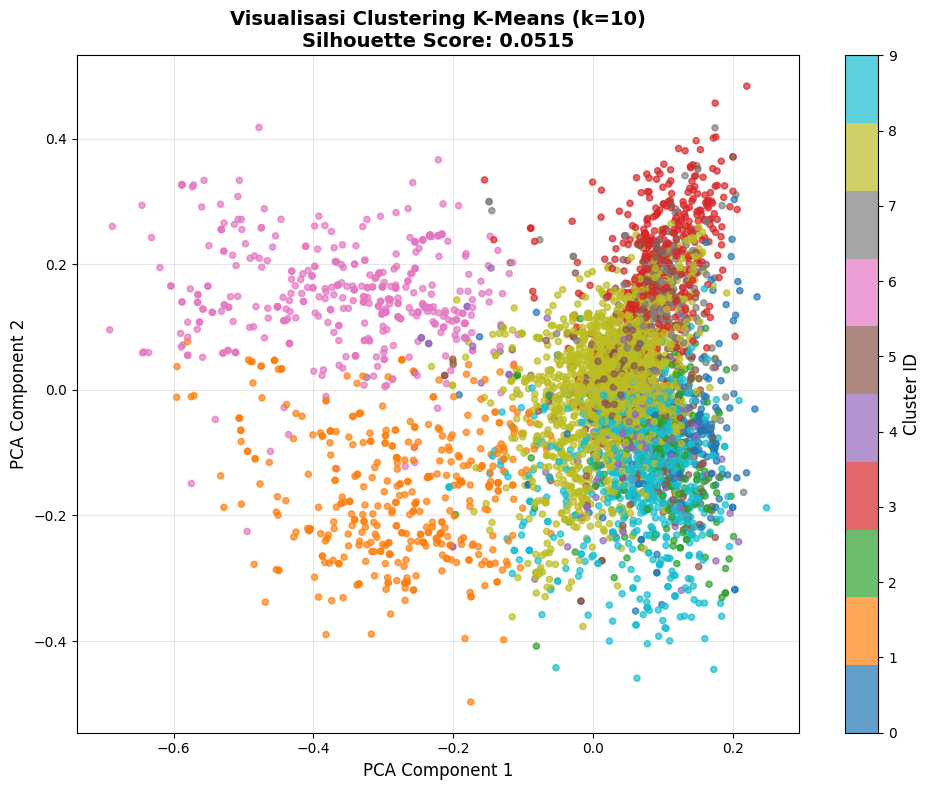

In [ ]:
# Evaluasi clustering dengan metrik eksternal (jika ada ground truth)
if 'label' in data_spam.columns:
    # Jika ada label asli (ground truth), hitung metrik eksternal
    true_labels = data_spam['label'].astype(str).values

    # Normalized Mutual Information (NMI): mengukur kesamaan informasi antara clustering dan ground truth
    nmi = normalized_mutual_info_score(true_labels, best_labels)
    print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

    # Adjusted Rand Index (ARI): mengukur kesamaan clustering dengan ground truth (0-1, 1 = perfect match)
    ari = adjusted_rand_score(true_labels, best_labels)
    print(f"Adjusted Rand Index (ARI): {ari:.4f}")

    print(f"\nInterpretasi:")
    print(f"- NMI > 0.5: clustering yang baik")
    print(f"- ARI > 0.3: clustering yang cukup baik")
    print(f"- ARI > 0.5: clustering yang sangat baik")

else:
    print("Ground truth labels tidak ditemukan; hanya melaporkan silhouette score.")

# Visualisasi clustering dalam 2D menggunakan PCA (lebih cepat dari UMAP)
print(f"\nMembuat visualisasi 2D dengan PCA (lebih cepat dari UMAP)...")

# Reduksi dimensi ke 2D untuk visualisasi menggunakan PCA
reducer = PCA(
    n_components=2,    # Reduksi ke 2 dimensi untuk plotting
    random_state=42    # Seed untuk reproduktibilitas
)
X_2d = reducer.fit_transform(X)

print(f"Variance explained by PCA: {reducer.explained_variance_ratio_.sum():.4f}")

# Plot hasil clustering
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    X_2d[:,0], X_2d[:,1],
    c=best_labels,           # Warna berdasarkan cluster
    cmap='tab10',           # Colormap dengan 10 warna berbeda
    s=20,                   # Ukuran titik
    alpha=0.7               # Transparansi
)

plt.title(f"Visualisasi Clustering K-Means (k={best_k})\nSilhouette Score: {best_row['silhouette']:.4f}",
          fontsize=14, fontweight='bold')
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)

# Tambahkan colorbar dengan label
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster ID', fontsize=12)

# Tambahkan grid untuk kemudahan membaca
plt.grid(True, alpha=0.3)

# Tampilkan informasi cluster
unique_labels = np.unique(best_labels)
print(f"\nJumlah cluster yang terbentuk: {len(unique_labels)}")
for label in unique_labels:
    count = np.sum(best_labels == label)
    percentage = (count / len(best_labels)) * 100
    print(f"Cluster {label}: {count} dokumen ({percentage:.1f}%)")

plt.tight_layout()
plt.show()

Evaluasi Clustering dengan Metrik Eksternal
* Mengevaluasi seberapa mirip hasil cluster (best_labels) dengan label asli (true_labels) jika dataset kamu punya kategori asli (misalnya "Ekonomi", "Olahraga", dll).

Reduksi Dimensi untuk Visualisasi
* PCA (Principal Component Analysis) digunakan untuk mereduksi dimensi dari 100 → 2 komponen utama.Supaya hasil clustering bisa divisualisasikan dalam grafik 2D.

Visualisasi Cluster

Membuat scatter plot 2D:

* Sumbu X = komponen PCA 1

* Sumbu Y = komponen PCA 2

* Warna titik = ID cluster hasil K-Means

Informasi Jumlah Dokumen per Cluster
* Menampilkan distribusi data di setiap cluster

## **Evaluasi**

Jumlah cluster yang terbentuk: 10

Cluster 0: 184 dokumen (3.3%)

Cluster 1: 408 dokumen (7.4%)

Cluster 2: 210 dokumen (3.8%)

Cluster 3: 425 dokumen (7.7%)

Cluster 4: 213 dokumen (3.9%)

Cluster 5: 400 dokumen (7.2%)

Cluster 6: 428 dokumen (7.7%)

Cluster 7: 186 dokumen (3.4%)

Cluster 8: 2273 dokumen (41.1%)

Cluster 9: 804 dokumen (14.5%)